TOC

- [Run Stan](#Run-Stan-model)
- [Post process](#Post-process)
    - [HMC](#HMC)
    - [Pair plots](#Pair-plots)
    - [Phase spaces](#Phase-spaces)
    - [PPC sEEG](#PPC-sEEG)

In [60]:
%pylab inline
# comment on lofi screen
%config InlineBackend.figure_format = 'retina'
import lib
lib.cmdstan_path('~/cmdstan-2.17.0');

Populating the interactive namespace from numpy and matplotlib


## Run Stan model

Compile first,

In [180]:
lib.compile_model('vep-fe-rev-05.stan')

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp
Model name=vep_fe_rev_05_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05 src/cmdstan/main.cpp -include /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp stan/lib/stan_math/lib/cvodes_2

Run multiple chains,

In [181]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.*.{out,csv}
for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=300 num_samples=200 \
        data file=data.R \
        output file=${model}.$i.csv refresh=10 &> ${model}.$i.out &
done

Check status..

In [170]:
!tail -n 1 vep-fe-rev-05.*.out
csv = lib.parse_csv('vep-fe-rev-05.*.csv', merge=False)

==> vep-fe-rev-05.1.out <==
Iteration: 290 / 500 [ 58%]  (Warmup)

==> vep-fe-rev-05.2.out <==
Iteration: 280 / 500 [ 56%]  (Warmup)

==> vep-fe-rev-05.3.out <==
Iteration: 330 / 500 [ 66%]  (Sampling)

==> vep-fe-rev-05.4.out <==



Maybe stop them if required..

In [171]:
!killall vep-fe-rev-05

## Post process

_NB_ following is based on git hash b3cd536, not the latest with constraints on time scale & prior on epsilon (which is running)



### HMC

Plot HMC stats (while running)

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


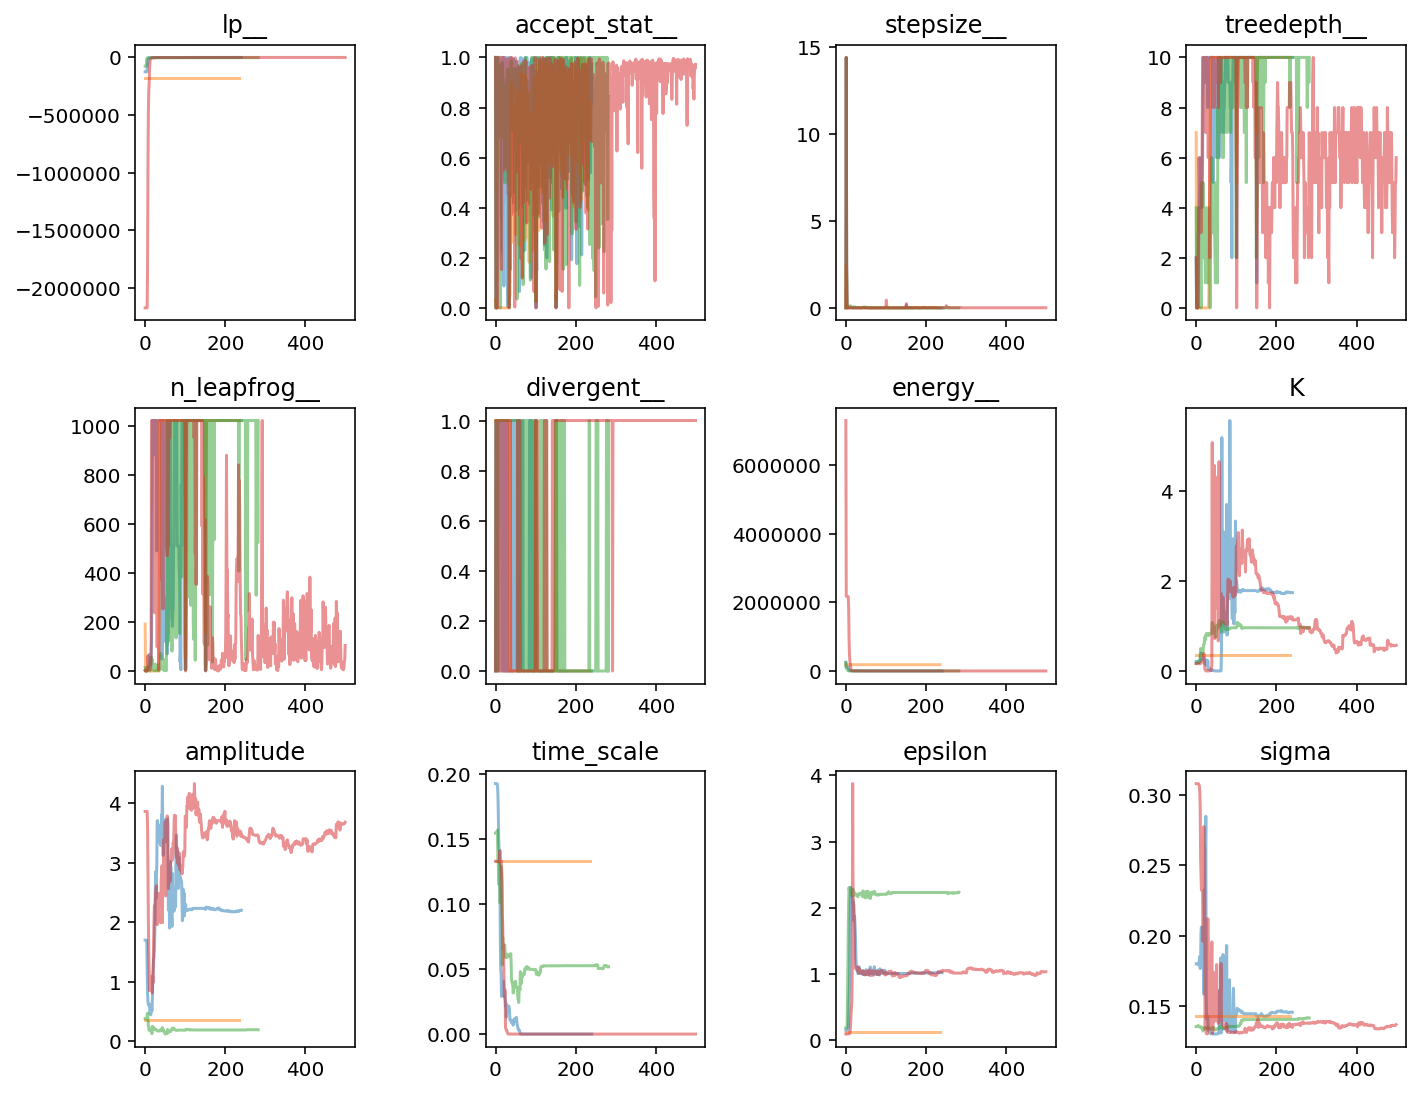

In [163]:
figure(figsize=(10, 10))
skip = 0
extras = 'K time_scale sigma epsilon amplitude'.split()
for csvi in csv:
    i = 1
    for key in csvi.keys():
        if key[-2:] == '__' or key in extras:
            subplot(4, 4, i)
            plot(csvi[key][skip:], alpha=0.5)
            title(key)
            i += 1
tight_layout()

### Pair plots

_Skip 150 warmup samples, plot different chains by color_

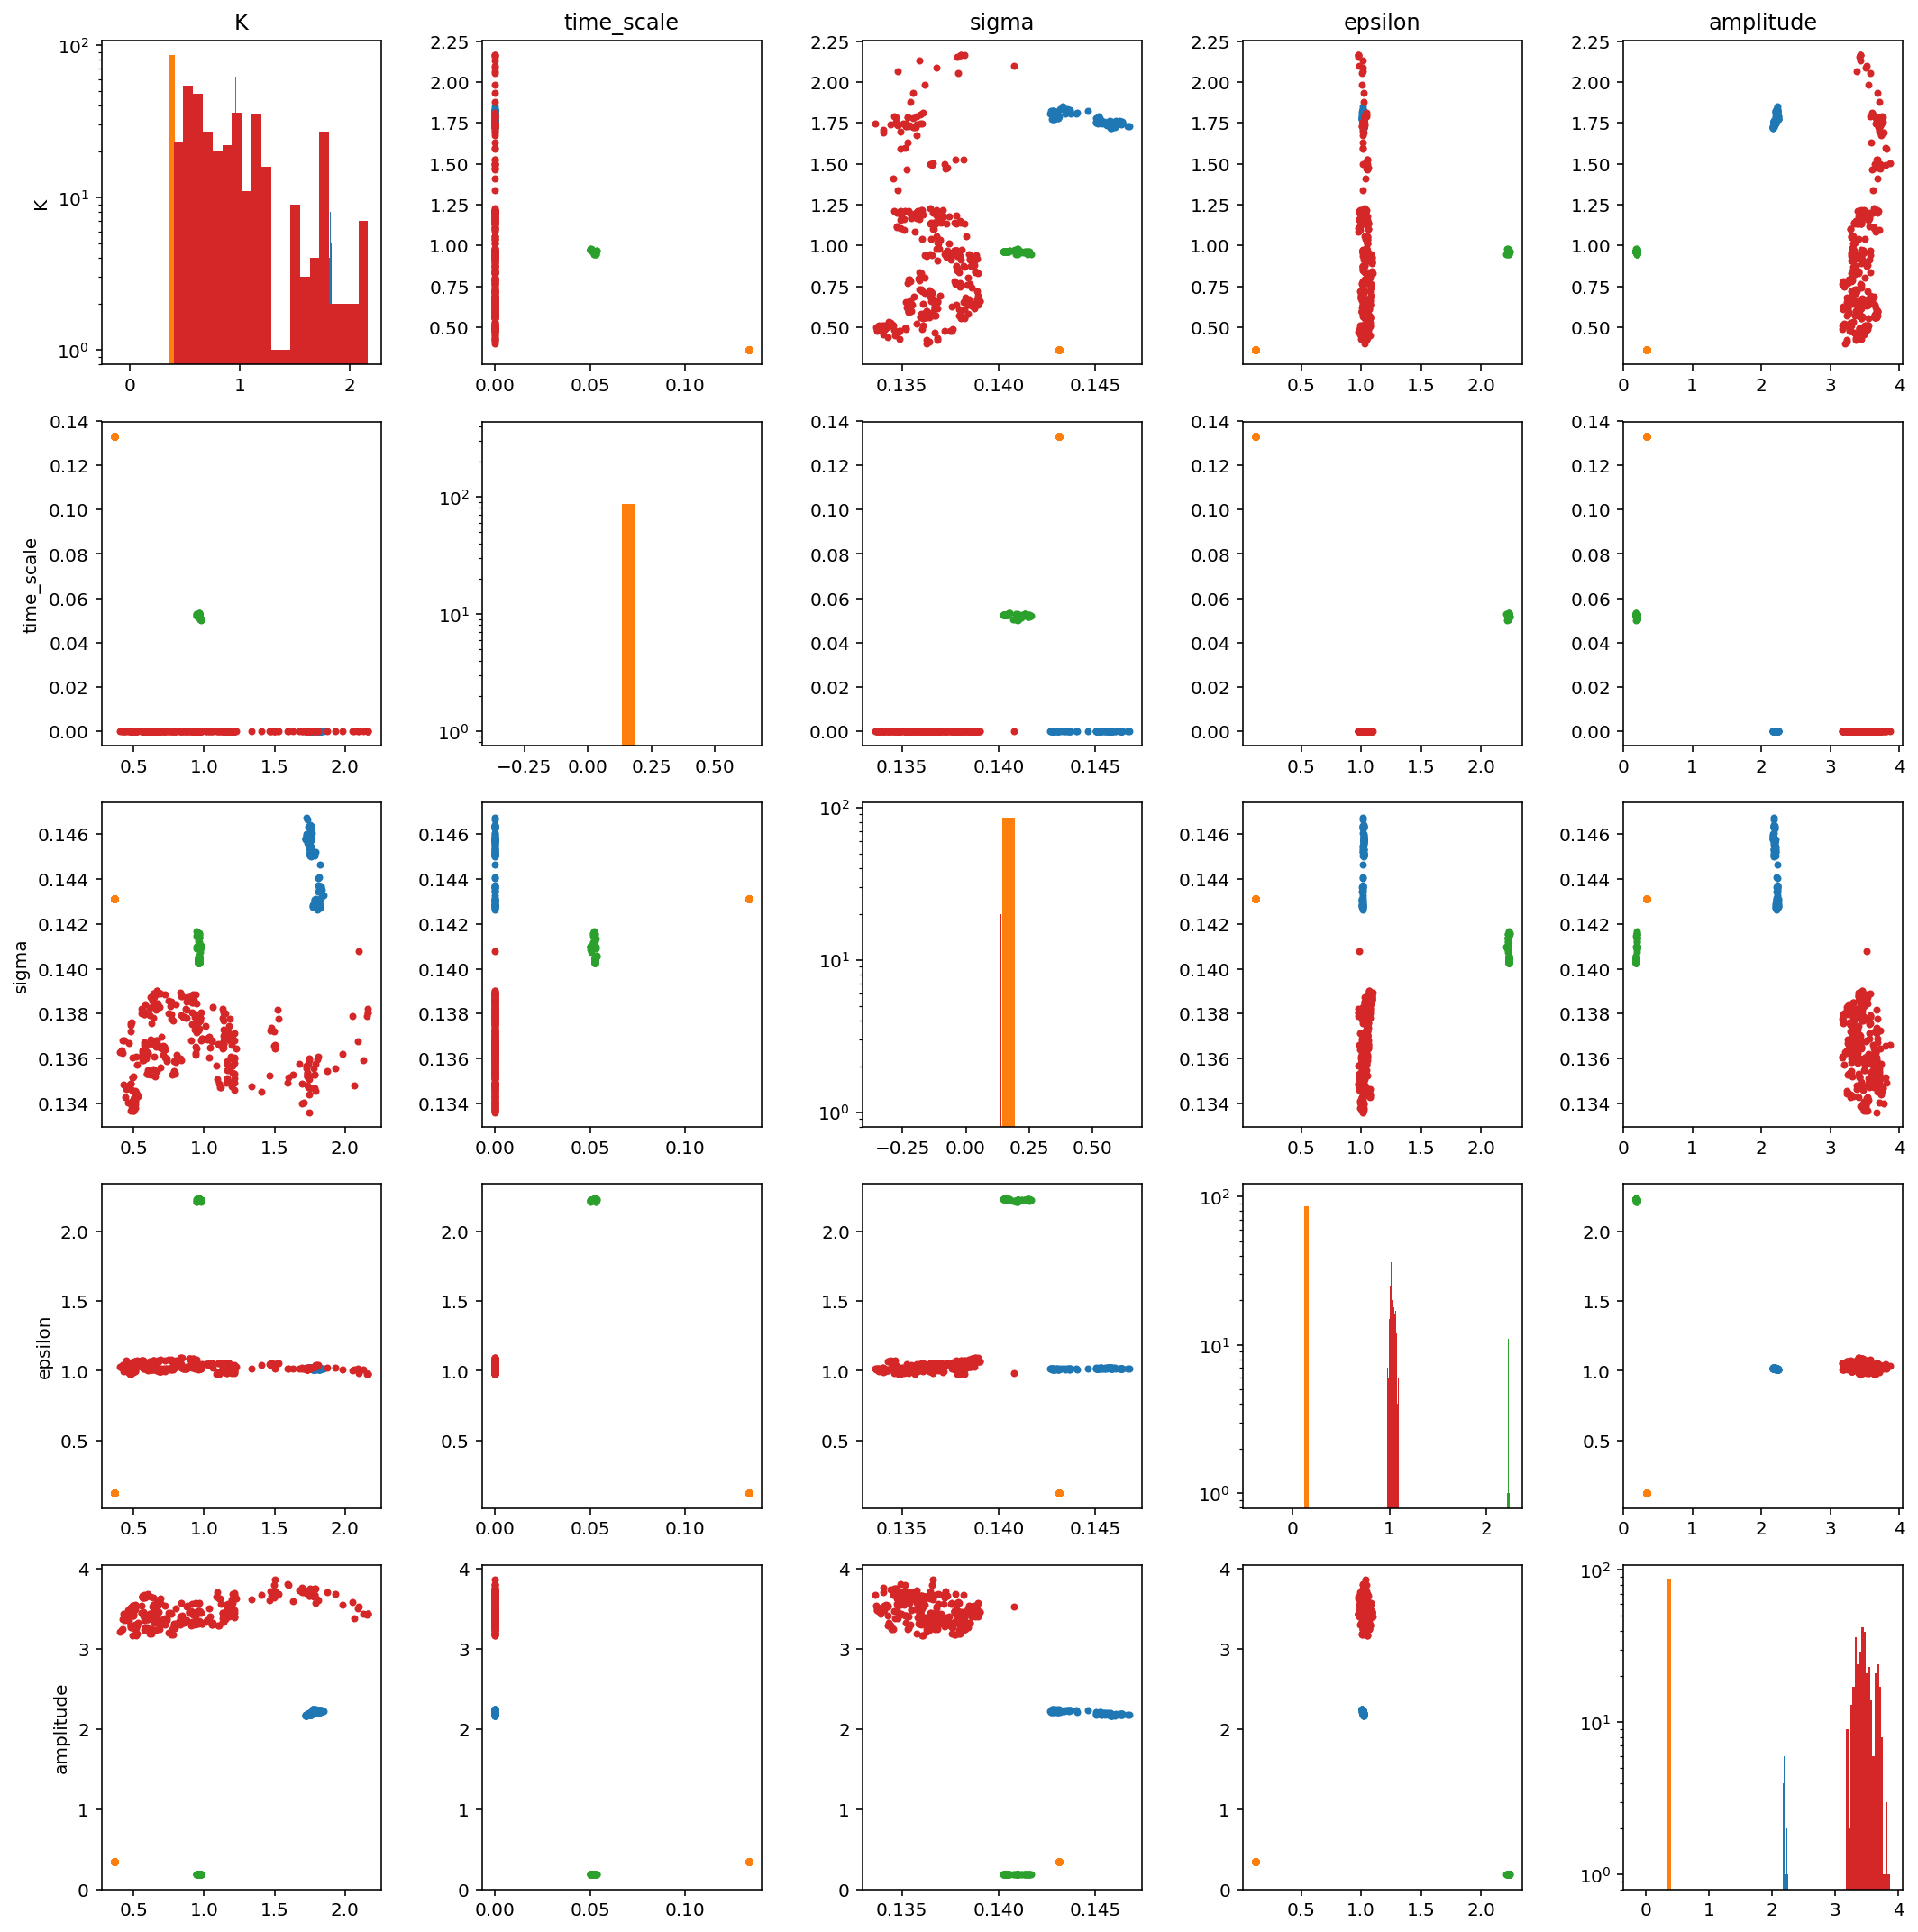

In [166]:
figure(figsize=(15, 15))
lib.reload()
lib.viz_pair_plots(csv, extras, skip=150)

There seem to be some correlations there, a SVD should tell us something..

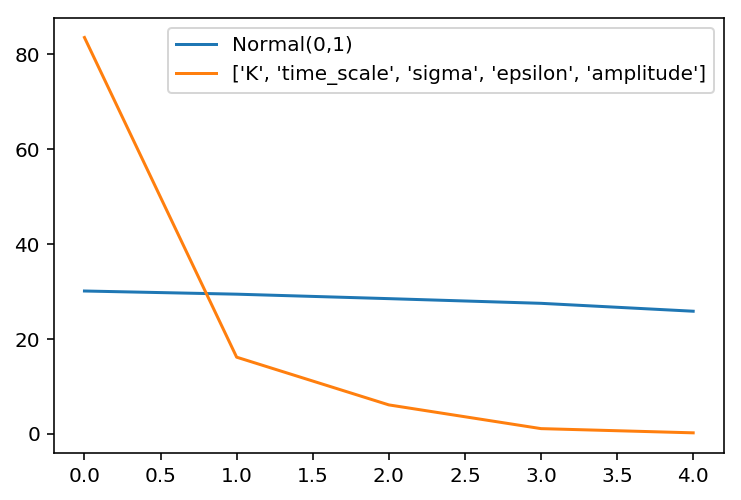

In [168]:
pars = np.array([csvi[k] for k in extras])
pars0 = randn(*pars.shape)*pars.std()
_, s0, _ = svd(pars0)
_, s1, _ = svd(pars, 0)

plot(s0, label='Normal(0,1)')
plot(s1, label=extras)
legend()

### Phase spaces

Phase space plots tell about the linear/nonlinear behavior of the neural mass model.  Specifically, the model predicts transition between healthy and seizure states when `x` passes from negative knee to positive knee.

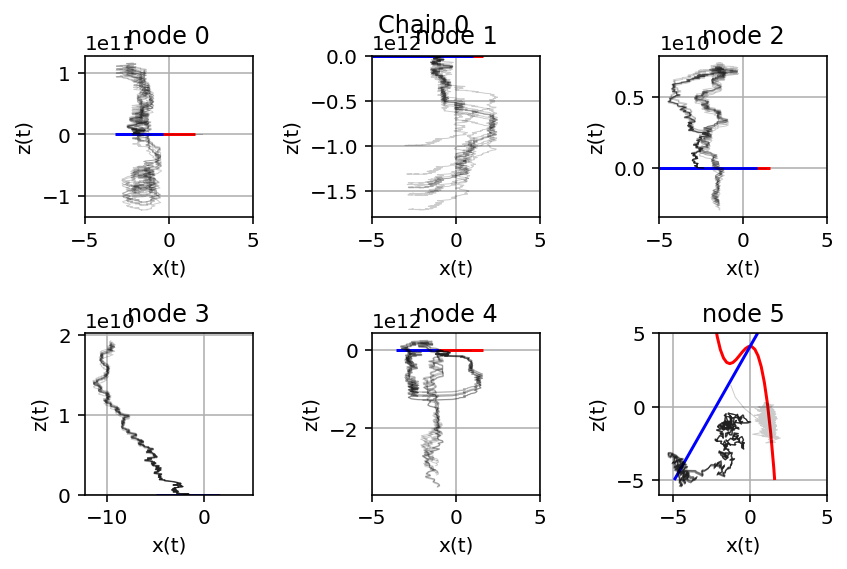

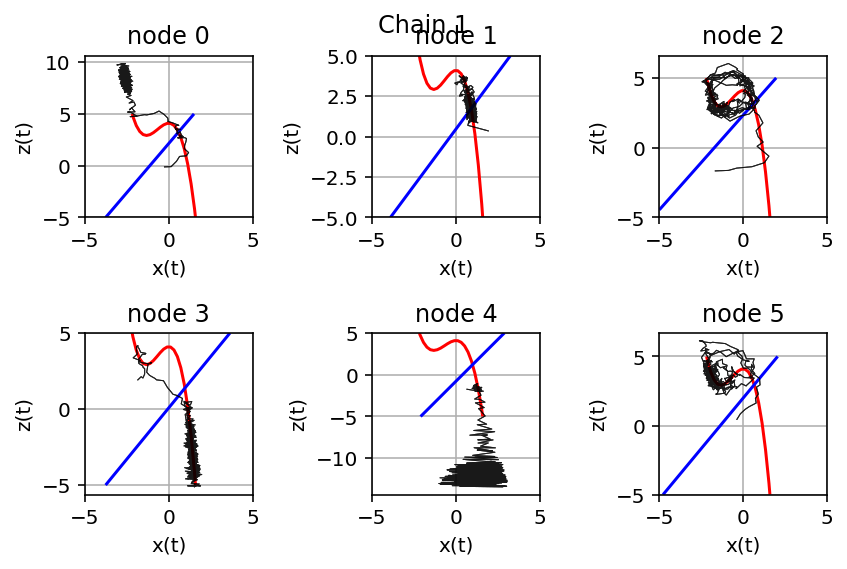

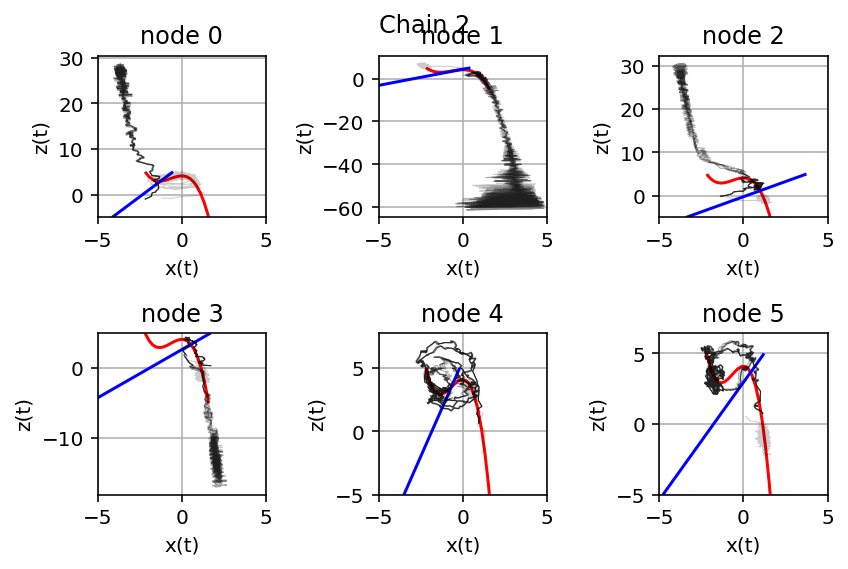

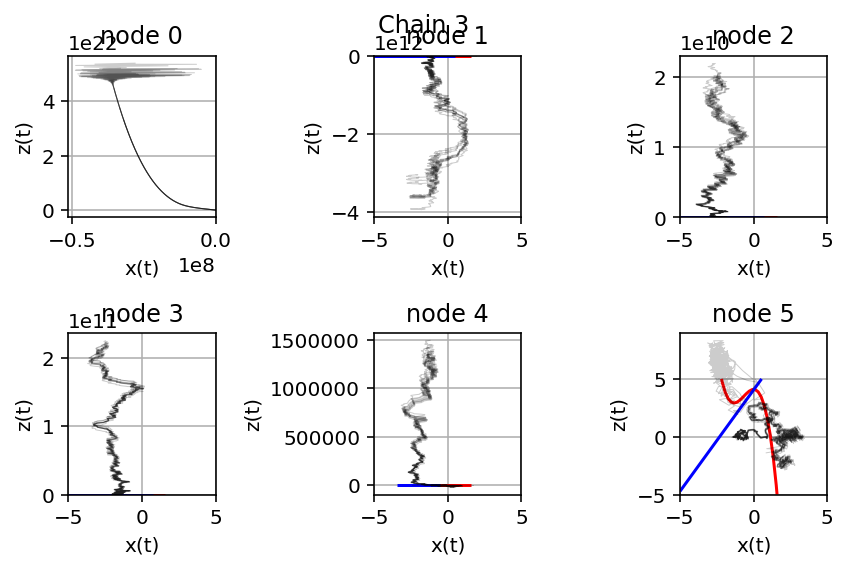

In [169]:
lib.reload()
for i, csvi in enumerate(csv):
    figure()
    lib.viz_phase_space(csvi)
    suptitle(f'Chain {i}')
    tight_layout()

Some chains running into instability.

### PPC sEEG

In [182]:
x = csv[2]['x'][:, :]
gain = np.load('data.R.npz')['gain']
x.shape, gain.shape

((334, 6, 466), (2, 6))

In [191]:
yh0, yh1 = gain.dot(x)
y0, y1 = np.load('data.R.npz')['seeg_log_power'].T

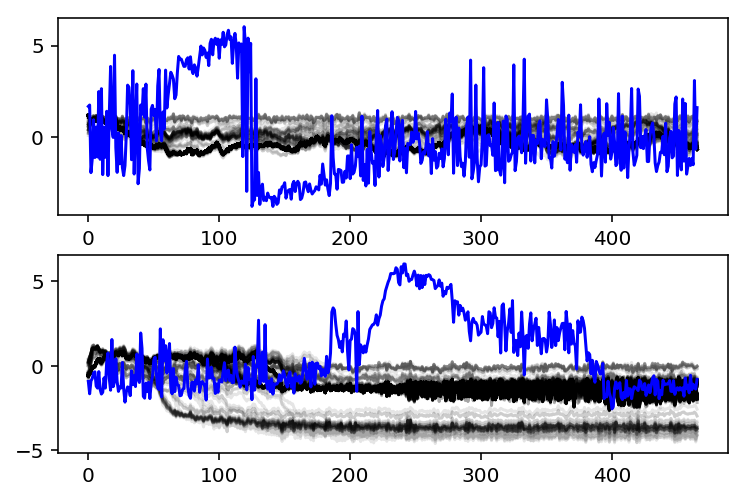

In [193]:
subplot(211)
plot(yh0.T, 'k', alpha=0.1);
plot(y0.T, 'b')

subplot(212)
plot(yh1.T, 'k', alpha=0.1);
plot(y1.T, 'b')

But this is pretty much unsatisfactory.   Issue is with `epsilon` being estimated at too high a value, to consider the model meaningful.